In [1]:
# -----------------------------------------------------------------------------
# 1. Imports and API wiring (reused pattern from Case B)
# -----------------------------------------------------------------------------

import os, sys, math
import numpy as np
import torch
import matplotlib.pyplot as plt
import importlib

# Ensure local package is importable (assumes this notebook is in project root)
root = os.getcwd()
if root not in sys.path:
    sys.path.insert(0, root)

# Imports from AdaPID and GuidedPID APIs
adapid = importlib.import_module("adapid_torch")
guided = importlib.import_module("guided_torch")
CaseA  = importlib.import_module("CaseA")

print("Ada API:", adapid.__file__)
print("Guided API:", getattr(guided, "__file__", None))
print("CaseA API:", getattr(CaseA, "__file__", None))

# Convenience aliases from CaseA API
SnapshotConfig                = CaseA.SnapshotConfig
simulate_caseA_with_snapshots = CaseA.simulate_caseA_with_snapshots
build_corridor_walls          = CaseA.build_corridor_walls

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Ada API: /Users/chertkov/Dropbox/Working/NewPID/GuidePID/11_23_25_GuideA+B/adapid_torch/__init__.py
Guided API: /Users/chertkov/Dropbox/Working/NewPID/GuidePID/11_23_25_GuideA+B/guided_torch/__init__.py
CaseA API: /Users/chertkov/Dropbox/Working/NewPID/GuidePID/11_23_25_GuideA+B/CaseA/__init__.py
Using device: cpu


In [2]:
# -----------------------------------------------------------------------------
# 1b. Autograd patch: redefine guided.ustar_guided WITHOUT @torch.no_grad
# -----------------------------------------------------------------------------

import torch

def _as_batch_local(Z: torch.Tensor) -> torch.Tensor:
    """Ensure Z has shape (M,d) by adding a batch dimension if needed."""
    if Z.dim() == 1:
        return Z.view(1, -1)
    return Z

def ustar_guided_autograd(X, t, sched, gmm):
    r"""Autograd-friendly guided optimal control u^*(t,x;Γ)."""
    # Ensure shape (M, d)
    Xb = _as_batch_local(X).to(gmm.MU.device)
    M, d = Xb.shape

    # Scalar coefficients
    a_m = sched.a_minus(float(t))    # a^-(t)
    b_m = sched.b_minus(float(t))    # b^-(t)

    # Guidance ν_t and linear term r^-(t)
    nu_t = sched.nu_sched.value(float(t)).to(Xb.device).view(1, d)
    r_t  = sched.rsminus.r_minus(float(t)).to(Xb.device).view(1, d)

    # Guided oracle ŷ(t;x;Γ)
    yhat = guided.yhat_gmm_guided(Xb, float(t), sched, gmm)

    if yhat.shape != Xb.shape:
        raise RuntimeError(
            f"ustar_guided_autograd: yhat shape {yhat.shape} does not match X shape {Xb.shape}"
        )

    # u = -a^- (x - ν_t) + b^- (ŷ - ν_t) + r^-
    u = -a_m * (Xb - nu_t) + b_m * (yhat - nu_t) + r_t
    return u

# Overwrite guided.ustar_guided with autograd-friendly version
guided.ustar_guided = ustar_guided_autograd
print("Patched guided.ustar_guided to autograd-friendly version.")


Patched guided.ustar_guided to autograd-friendly version.


In [3]:

# -----------------------------------------------------------------------------
# 2. Case C configuration: multi-task GMMs, intrinsic corridor frame, exact PoE
# -----------------------------------------------------------------------------

print("Using device:", device)

# PWC configuration (as in Case B)
K_pwc = 20
splits_pwc = np.linspace(0.0, 1.0, K_pwc + 1)

# Sampling configuration
M_samples = 4000
snap_cfg_caseC = SnapshotConfig(T=3000, n_save=10)

# -----------------------------------------------------------------------------
# Expert task GMMs p1(x), p2(x)
# -----------------------------------------------------------------------------

def make_caseC_task1_gmm():
    """
    Expert 1 (p1): 3 tight, distinct modes.
    Designed to define 3 of the potential final modes.
    """
    mu = np.array([
        [-1.0,  0.0],   # left
        [ 1.0,  0.0],   # right
        [ 0.0, -2.5],   # bottom
    ], dtype=np.float32)

    cov = np.array([
        # Mode 1: horizontally elongated
        [[0.30, 0.0],
         [0.0,  0.10]],
        # Mode 2: vertically elongated
        [[0.10, 0.0],
         [0.0,  0.40]],
        # Mode 3: rotated / more diffuse
        [[0.20, 0.10],
         [0.10, 0.40]],
    ], dtype=np.float32)

    w = np.array([0.5, 0.4, 0.1], dtype=np.float32)
    w /= w.sum()
    return mu, cov, w


def make_caseC_task2_gmm():
    """
    Expert 2 (p2): 2 broad, centrally located modes.
    Designed to split/merge modes depending on its exponent.
    """
    mu = np.array([
        [-1.5, -2.5],   # bottom-left
        [ 1.5, -2.5],   # bottom-right
    ], dtype=np.float32)

    cov = np.array([
        # Mode 1: vertically elongated and broad
        [[0.6, 0.0],
         [0.0, 1.5]],
        # Mode 2: moderately broad
        [[0.2, 0.0],
         [0.0, 0.4]],
    ], dtype=np.float32)

    w = np.array([0.5, 0.5], dtype=np.float32)
    w /= w.sum()
    return mu, cov, w


mu1, cov1, w1 = make_caseC_task1_gmm()
mu2, cov2, w2 = make_caseC_task2_gmm()

print("Case C task 1: modes =", mu1.shape[0])
print("Case C task 2: modes =", mu2.shape[0])

# -----------------------------------------------------------------------------
# Exact product-of-Gaussian experts (building block for PoE of GMMs)
# -----------------------------------------------------------------------------

import numpy as _np
import math as _math

def gaussian_product_params(m1, C1, m2, C2):
    """
    Exact product of two Gaussians N(m1,C1) * N(m2,C2) = Z * N(m*, C*).
    Returns (m_star, C_star, logZ).
    All inputs are NumPy arrays.
    """
    m1 = _np.asarray(m1, dtype=_np.float64)
    m2 = _np.asarray(m2, dtype=_np.float64)
    C1 = _np.asarray(C1, dtype=_np.float64)
    C2 = _np.asarray(C2, dtype=_np.float64)

    d = m1.shape[0]

    invC1 = _np.linalg.inv(C1)
    invC2 = _np.linalg.inv(C2)

    invC_star = invC1 + invC2
    C_star = _np.linalg.inv(invC_star)

    m_star = C_star @ (invC1 @ m1 + invC2 @ m2)

    # log normalizers
    sign1, logdetC1 = _np.linalg.slogdet(C1)
    sign2, logdetC2 = _np.linalg.slogdet(C2)
    signS, logdetC_star = _np.linalg.slogdet(C_star)

    if sign1 <= 0 or sign2 <= 0 or signS <= 0:
        raise RuntimeError("Non-positive definite covariance in gaussian_product_params.")

    quad1 = (m_star - m1) @ (invC1 @ (m_star - m1))
    quad2 = (m_star - m2) @ (invC2 @ (m_star - m2))

    logp1 = -0.5 * (quad1 + logdetC1 + d * _math.log(2.0 * _math.pi))
    logp2 = -0.5 * (quad2 + logdetC2 + d * _math.log(2.0 * _math.pi))

    # Density of N(m_star, C_star) at its own mean
    logp_star = -0.5 * (0.0 + logdetC_star + d * _math.log(2.0 * _math.pi))

    logZ = logp1 + logp2 - logp_star
    return m_star.astype(_np.float32), C_star.astype(_np.float32), float(logZ)


def _logsumexp(logw):
    m = _np.max(logw)
    return m + _np.log(_np.sum(_np.exp(logw - m)))


def fuse_gmms_product_of_experts_exact(mu1, cov1, w1, mu2, cov2, w2, k1=1, k2=1):
    """
    Exact product-of-experts for (p1)^k1 (p2)^k2 where p1, p2 are GMMs.

    If p1(x) = sum_i w1_i N(m1_i, C1_i),
       p2(x) = sum_j w2_j N(m2_j, C2_j),

    then (p1)^k1 (p2)^k2 is expanded exactly as a mixture over
    all k1 copies of p1 and k2 copies of p2, with componentwise
    Gaussian products.

    Assumes k1, k2 are small positive integers (here only 1 or 2).
    """
    mu1 = _np.asarray(mu1, dtype=_np.float32)
    cov1 = _np.asarray(cov1, dtype=_np.float32)
    w1 = _np.asarray(w1, dtype=_np.float32)

    mu2 = _np.asarray(mu2, dtype=_np.float32)
    cov2 = _np.asarray(cov2, dtype=_np.float32)
    w2 = _np.asarray(w2, dtype=_np.float32)

    K1 = mu1.shape[0]
    K2 = mu2.shape[0]
    d  = mu1.shape[1]

    from itertools import product

    # All index tuples for p1 and p2
    idxs1_list = list(product(range(K1), repeat=k1)) if k1 > 0 else [()]
    idxs2_list = list(product(range(K2), repeat=k2)) if k2 > 0 else [()]

    mus_star = []
    covs_star = []
    log_weights = []

    for idxs1 in idxs1_list:
        for idxs2 in idxs2_list:
            comps = []

            for i in idxs1:
                comps.append((mu1[i], cov1[i], _math.log(float(w1[i]))))
            for j in idxs2:
                comps.append((mu2[j], cov2[j], _math.log(float(w2[j]))))

            # Combine all Gaussians in 'comps'
            m_curr, C_curr = comps[0][0], comps[0][1]
            logw_total = comps[0][2]

            for (m_next, C_next, logw_next) in comps[1:]:
                m_curr, C_curr, logZ_pair = gaussian_product_params(m_curr, C_curr, m_next, C_next)
                logw_total = logw_total + logw_next + logZ_pair

            mus_star.append(m_curr)
            covs_star.append(C_curr)
            log_weights.append(logw_total)

    mus_star = _np.stack(mus_star, axis=0).astype(_np.float32)
    covs_star = _np.stack(covs_star, axis=0).astype(_np.float32)
    log_weights = _np.asarray(log_weights, dtype=_np.float64)

    # Normalize weights
    logZ_all = _logsumexp(log_weights)
    w_star = _np.exp(log_weights - logZ_all).astype(_np.float32)

    return mus_star, covs_star, w_star


# Default commander exponents (equal trust) for initial fused GMM
k1_default, k2_default = 1, 1
mu_fused, cov_fused, w_fused = fuse_gmms_product_of_experts_exact(
    mu1, cov1, w1, mu2, cov2, w2, k1=k1_default, k2=k2_default
)
print("Initial fused target (k1=k2=1): modes =", mu_fused.shape[0])

# -----------------------------------------------------------------------------
# Intrinsic frame: x_in, x_out, e_axis, n_axis
# -----------------------------------------------------------------------------

x_in   = np.zeros(2, dtype=np.float32)
x_out1 = np.average(mu1, axis=0, weights=w1)
x_out2 = np.average(mu2, axis=0, weights=w2)
x_out  = np.average(mu_fused, axis=0, weights=w_fused)

v_axis = x_out - x_in
L_axis = np.linalg.norm(v_axis)
if L_axis <= 0:
    raise RuntimeError("Degenerate axis: x_in and x_out coincide.")

e_axis = v_axis / L_axis
n_axis = np.array([-e_axis[1], e_axis[0]], dtype=np.float32)

def x_axis(s: float) -> np.ndarray:
    """Point on the axis segment for progress s ∈ [0, 1]."""
    return x_in + float(s) * v_axis

print("Intrinsic frame:")
print("  x_in   =", x_in)
print("  x_out1 =", x_out1)
print("  x_out2 =", x_out2)
print("  x_out  =", x_out)
print("  e_axis =", e_axis)
print("  n_axis =", n_axis)

# Build fused GMMTorch target from the default exponents
MU_fused  = torch.from_numpy(mu_fused).to(device)
COV_fused = torch.from_numpy(cov_fused).to(device)
W_fused   = torch.from_numpy(w_fused).to(device)
gmm_fused = adapid.GMMTorch(MU_fused, COV_fused, W_fused).to(device)

# Precompute for log-density helper
CINV_fused    = torch.linalg.inv(COV_fused)
logdetC_fused = torch.logdet(COV_fused)


Using device: cpu
Case C task 1: modes = 3
Case C task 2: modes = 2
Initial fused target (k1=k2=1): modes = 6
Intrinsic frame:
  x_in   = [0. 0.]
  x_out1 = [-0.09999999 -0.25      ]
  x_out2 = [ 0.  -2.5]
  x_out  = [-0.50718415 -1.0474275 ]
  e_axis = [-0.4358146  -0.90003645]
  n_axis = [ 0.90003645 -0.4358146 ]



[Diagnostic] Fusing GMMs with exponents k1=1, k2=2
  Fused modes: 12
  Weights (sorted): [1.0533207e-06 2.0883028e-06 2.0883031e-06 2.8316453e-04 1.0571054e-03
 1.0571055e-03 8.8039413e-03 8.8039432e-03 2.0374759e-01 2.4207482e-01
 2.5850403e-01 2.7566308e-01]


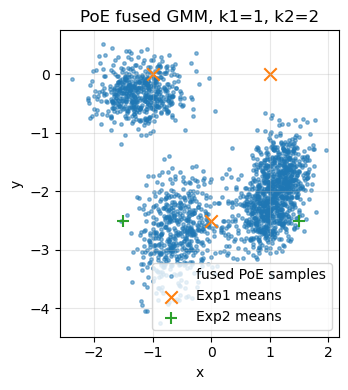


[Diagnostic] Fusing GMMs with exponents k1=1, k2=1
  Fused modes: 6
  Weights (sorted): [4.0225754e-05 8.3215563e-03 1.0632841e-01 1.1687474e-01 2.1326789e-01
 5.5516714e-01]


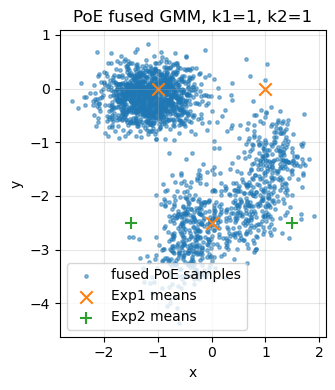


[Diagnostic] Fusing GMMs with exponents k1=2, k2=1
  Fused modes: 18
  Weights (sorted): [1.79099317e-07 1.79099317e-07 2.76120704e-06 1.56076912e-05
 1.56076912e-05 2.38036901e-05 2.38036901e-05 1.06672764e-04
 1.06672764e-04 2.47883843e-04 2.47883843e-04 1.43959629e-03
 1.43959629e-03 5.87546406e-03 1.18913827e-02 4.07258049e-02
 4.11731824e-02 8.96663904e-01]


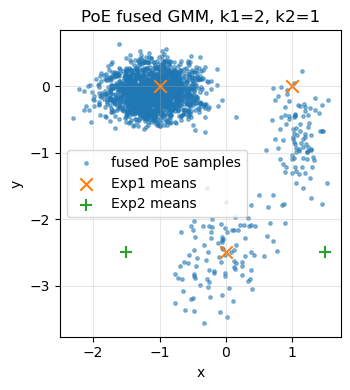

In [4]:

# -------------------------------------------------------------------------
# 3. Diagnostic: PoE fused GMMs for three (k1, k2) trust configurations
# -------------------------------------------------------------------------

def fuse_for_trust_configs(trust_list, N_samples=2000):
    """
    For each (k1, k2) in trust_list:
      - Fuse GMMs via exact product-of-experts.
      - Sample points for visualization.
    """
    rng = np.random.default_rng(2027)

    try:
        from adapid_torch import sample_gmm_numpy as sample_gmm_np
    except Exception:
        sample_gmm_np = None

    def sample_any_gmm(mu, cov, w, N, rng):
        if sample_gmm_np is not None:
            return sample_gmm_np(mu, cov, w, N, rng)
        else:
            X = np.zeros((N, mu.shape[1]), dtype=np.float32)
            K = mu.shape[0]
            for n in range(N):
                k = rng.choice(K, p=w)
                X[n, :] = rng.multivariate_normal(mu[k], cov[k]).astype(np.float32)
            return X

    for (k1_cfg, k2_cfg) in trust_list:
        print(f"\n[Diagnostic] Fusing GMMs with exponents k1={k1_cfg}, k2={k2_cfg}")
        mu_f, cov_f, w_f = fuse_gmms_product_of_experts_exact(
            mu1, cov1, w1, mu2, cov2, w2, k1=k1_cfg, k2=k2_cfg
        )
        print("  Fused modes:", mu_f.shape[0])
        print("  Weights (sorted):", np.sort(w_f))

        X_f = sample_any_gmm(mu_f, cov_f, w_f, N_samples, rng)

        plt.figure(figsize=(4.5, 4))
        plt.scatter(X_f[:, 0], X_f[:, 1], s=6, alpha=0.5, label="fused PoE samples")
        plt.scatter(mu1[:, 0], mu1[:, 1], marker="x", s=80, label="Exp1 means")
        plt.scatter(mu2[:, 0], mu2[:, 1], marker="+", s=80, label="Exp2 means")
        plt.title(f"PoE fused GMM, k1={k1_cfg}, k2={k2_cfg}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend(loc="best")
        plt.gca().set_aspect("equal", adjustable="box")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


# Run diagnostics for the three trust configurations of interest
trust_configs_diag = [(1, 2), (1, 1), (2, 1)]
fuse_for_trust_configs(trust_configs_diag, N_samples=2000)


In [5]:
# -----------------------------------------------------------------------------
# 3. Teacher protocols for Case C: two clearly competing S-curves
# -----------------------------------------------------------------------------

# Teacher 1: moderate S-shaped swing around the corridor axis.
# Teacher 2: stronger and shifted upward S-shaped swing.
A1 = 0.7      # amplitude for teacher 1 (moderate swing)
A2 = 1.4      # amplitude for teacher 2 (stronger swing)
delta_y = 1.0 # upward offset for teacher 2 in the transverse (n_axis) direction
kappa = 6.0   # sharpness of S

def nu1_raw(t: float) -> np.ndarray:
    """Uncorrected S-shaped teacher centerline for task 1 (around corridor axis)."""
    t = float(t)
    y = A1 * np.tanh(kappa * (2.0 * t - 1.0))
    return (x_axis(t) + y * n_axis).astype(np.float32)

def nu2_raw(t: float) -> np.ndarray:
    """Uncorrected S-shaped teacher centerline for task 2 (higher and stronger swing)."""
    t = float(t)
    y = A2 * np.tanh(kappa * (2.0 * t - 1.0)) + delta_y
    return (x_axis(t) + y * n_axis).astype(np.float32)

# Enforce common endpoints for both teacher curves
nu1_raw_0 = nu1_raw(0.0)
nu1_raw_1 = nu1_raw(1.0)
nu2_raw_0 = nu2_raw(0.0)
nu2_raw_1 = nu2_raw(1.0)

def bar_nu1_cont(t: float) -> np.ndarray:
    """Continuous teacher curve barν^{(1)}(t) with enforced endpoints."""
    t = float(t)
    base = nu1_raw(t)
    return (base
            + (1.0 - t) * (x_in - nu1_raw_0)
            + t * (x_out1 - nu1_raw_1)).astype(np.float32)

def bar_nu2_cont(t: float) -> np.ndarray:
    """Continuous teacher curve barν^{(2)}(t) with enforced endpoints."""
    t = float(t)
    base = nu2_raw(t)
    return (base
            + (1.0 - t) * (x_in - nu2_raw_0)
            + t * (x_out2 - nu2_raw_1)).astype(np.float32)

# PWC sampling for both teachers and stiffness (same pattern as before)
beta_const = 20.0

def bar_beta_cont(t: float) -> float:
    _ = t
    return float(beta_const)

bar_nu1_vals = np.zeros((K_pwc, 2), dtype=np.float32)
bar_nu2_vals = np.zeros((K_pwc, 2), dtype=np.float32)
for k in range(K_pwc):
    t_mid = 0.5 * (splits_pwc[k] + splits_pwc[k+1])
    bar_nu1_vals[k, :] = bar_nu1_cont(t_mid)
    bar_nu2_vals[k, :] = bar_nu2_cont(t_mid)

bar_nu1_vals[0, :]  = x_in
bar_nu1_vals[-1, :] = x_out1
bar_nu2_vals[0, :]  = x_in
bar_nu2_vals[-1, :] = x_out2

bar_beta_vals = np.full(K_pwc, beta_const, dtype=np.float32)

print("Teacher bar_nu1_vals (PWC, task 1):")
print(bar_nu1_vals)
print("Teacher bar_nu2_vals (PWC, task 2):")
print(bar_nu2_vals)
print("Teacher bar_beta_vals (PWC, constant):", bar_beta_vals)


Teacher bar_nu1_vals (PWC, task 1):
[[ 0.          0.        ]
 [-0.10196355  0.02699104]
 [-0.16985673  0.04494511]
 [-0.23749788  0.0627771 ]
 [-0.30430394  0.08020478]
 [-0.36835197  0.09629694]
 [-0.42340326  0.10803273]
 [-0.45026207  0.10611716]
 [-0.39928335  0.06651115]
 [-0.19953349 -0.04513252]
 [ 0.09953354 -0.20486754]
 [ 0.29928333 -0.31651115]
 [ 0.35026205 -0.35611713]
 [ 0.32340324 -0.35803276]
 [ 0.26835194 -0.3462969 ]
 [ 0.204304   -0.33020484]
 [ 0.13749792 -0.3127771 ]
 [ 0.06985673 -0.294945  ]
 [ 0.00196354 -0.276991  ]
 [-0.09999999 -0.25      ]]
Teacher bar_nu2_vals (PWC, task 2):
[[ 0.          0.        ]
 [-0.18892711 -0.09601793]
 [-0.31471342 -0.16010986]
 [-0.43999574 -0.22444576]
 [-0.5636078  -0.28959048]
 [-0.6817039  -0.35740614]
 [-0.78180647 -0.43393457]
 [-0.825524   -0.53776574]
 [-0.7135665  -0.7169777 ]
 [-0.3040668  -1.0402651 ]
 [ 0.30406702 -1.459735  ]
 [ 0.7135666  -1.7830223 ]
 [ 0.8255242  -1.9622344 ]
 [ 0.7818067  -2.0660655 ]
 [ 0.6817

[Figure] Saved Case C multi-trust GMM visualization to: results_caseC/caseC_gmms_and_guides_trust_panels_bis.png


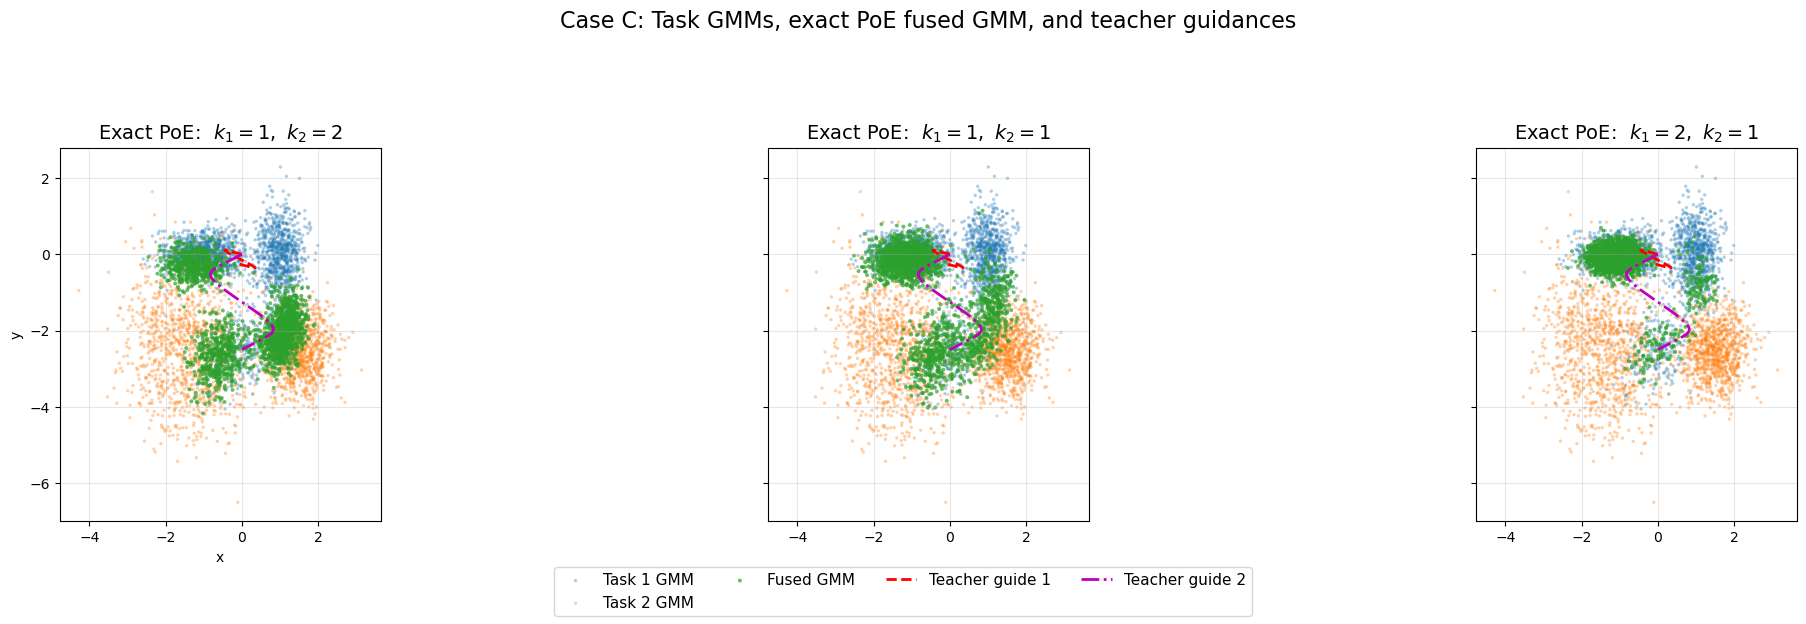

In [7]:
# -----------------------------------------------------------------------------
# Visualization: Task GMMs, fused GMM (PoE) for different (k₁,k₂), and teacher guides
# -----------------------------------------------------------------------------

os.makedirs("results_caseC", exist_ok=True)

N_vis = 2000
rng_vis = np.random.default_rng(2026)

# --- Simple local GMM sampler (no external dependencies) ---------------------
def sample_gmm_numpy(mu, cov, w, N, rng):
    """
    Simple NumPy GMM sampler: choose component by weights w, then
    draw from N(mu_k, cov_k). All inputs assumed on CPU as numpy arrays.
    """
    mu  = np.asarray(mu,  dtype=np.float32)   # (K, d)
    cov = np.asarray(cov, dtype=np.float32)   # (K, d, d)
    w   = np.asarray(w,   dtype=np.float32)   # (K,)

    K, d = mu.shape
    X = np.zeros((N, d), dtype=np.float32)

    for i in range(N):
        k = rng.choice(K, p=w)
        X[i, :] = rng.multivariate_normal(mu[k], cov[k]).astype(np.float32)

    return X

# Samples from the two task GMMs (independent of trust parameters)
X1 = sample_gmm_numpy(mu1, cov1, w1, N_vis, rng_vis)
X2 = sample_gmm_numpy(mu2, cov2, w2, N_vis, rng_vis)

# Teacher curves (dense parametric plots)
t_dense = np.linspace(0.0, 1.0, 500)
curve1 = np.stack([bar_nu1_cont(float(t)) for t in t_dense], axis=0)
curve2 = np.stack([bar_nu2_cont(float(t)) for t in t_dense], axis=0)

# Trust configurations (commander credibility choices)
trust_configs = [(1, 2), (1, 1), (2, 1)]

# Larger figure
fig, axes = plt.subplots(
    1, len(trust_configs),
    figsize=(7.5 * len(trust_configs), 6),
    sharex=True, sharey=True
)

if len(trust_configs) == 1:
    axes = [axes]

# Common axis limits based on the two task GMMs
x_min = min(X1[:, 0].min(), X2[:, 0].min()) - 0.5
x_max = max(X1[:, 0].max(), X2[:, 0].max()) + 0.5
y_min = min(X1[:, 1].min(), X2[:, 1].min()) - 0.5
y_max = max(X1[:, 1].max(), X2[:, 1].max()) + 0.5

# ------------------------------
# Main multi-panel loop
# ------------------------------
for ax, (k1_cfg, k2_cfg) in zip(axes, trust_configs):

    # Fuse GMMs via exact PoE for this (k₁, k₂)
    mu_f, cov_f, w_f = fuse_gmms_product_of_experts_exact(
        mu1, cov1, w1, mu2, cov2, w2,
        k1=k1_cfg, k2=k2_cfg
    )

    Xf = sample_gmm_numpy(mu_f, cov_f, w_f, N_vis, rng_vis)

    # Plot task GMM samples and fused samples
    ax.scatter(X1[:, 0], X1[:, 1], s=6, alpha=0.35,
               label="Task 1 GMM", edgecolors="none")
    ax.scatter(X2[:, 0], X2[:, 1], s=6, alpha=0.35,
               label="Task 2 GMM", edgecolors="none")
    ax.scatter(Xf[:, 0], Xf[:, 1], s=8, alpha=0.70,
               label="Fused GMM", edgecolors="none")

    # Teacher curves
    ax.plot(curve1[:, 0], curve1[:, 1], "r--", linewidth=2.0,
            label="Teacher guide 1")
    ax.plot(curve2[:, 0], curve2[:, 1], "m-.", linewidth=2.0,
            label="Teacher guide 2")

    ax.set_title(rf"Exact PoE:  $k_1={k1_cfg},\ k_2={k2_cfg}$", fontsize=14)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(alpha=0.3)
    ax.set_aspect("equal", adjustable="box")

# Shared labels
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

# Legend below panels
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=4, fontsize=11)

fig.suptitle("Case C: Task GMMs, exact PoE fused GMM, and teacher guidances",
             fontsize=16, y=1.02)

plt.tight_layout(rect=[0, 0.07, 1, 0.92])

vis_path = os.path.join("results_caseC", "caseC_gmms_and_guides_trust_panels_bis.png")
plt.savefig(vis_path, dpi=200, bbox_inches="tight")
print("[Figure] Saved Case C multi-trust GMM visualization to:", vis_path)
plt.show()


In [8]:
# -----------------------------------------------------------------------------
# 4. Helper: build autograd GH–PID schedule from PWC β and learnable ν
# -----------------------------------------------------------------------------

def build_schedule_from_param(beta_vals_np: np.ndarray,
                              nu_param: torch.Tensor,
                              d: int,
                              device: torch.device):
    beta_vals_np = np.asarray(beta_vals_np, dtype=np.float32)

    beta_sched = guided.BetaSchedulePWCTorch(beta_vals_np, splits_pwc)
    nu_sched   = guided.NuPWC(
        values=nu_param,
        splits=torch.tensor(splits_pwc, dtype=torch.float32, device=device),
    )
    rsminus = guided.build_rsminus_pwc(beta_sched, nu_sched, d=d, device=device)
    splus1  = guided.s_plus_terminal(beta_sched, nu_sched, d=d, device=device)
    sched   = guided.GuidedPWCSchedule(
        beta_sched=beta_sched,
        nu_sched=nu_sched,
        rsminus=rsminus,
        splus1=splus1,
    )
    return sched


In [9]:
# -----------------------------------------------------------------------------
# Manual log-density for fused GMM (used in J_CE)
# -----------------------------------------------------------------------------

LOG_2PI = math.log(2.0 * math.pi)

# Precompute inverses and log-determinants once (on current device)
CINV_fused   = torch.linalg.inv(COV_fused)        # (K, d, d)
logdetC_fused = torch.logdet(COV_fused)           # (K,)


def gmm_fused_log_prob(X: torch.Tensor) -> torch.Tensor:
    """Compute log rho_tar(x) for the fused GMM, for X of shape (M, d).

    rho_tar(x) = sum_k w_k N(x; mu_k, Sigma_k)
    log rho_tar(x) = log sum_k w_k N(x; mu_k, Sigma_k).
    """
    # X: (M, d)
    M, d = X.shape

    # diff: (M, K, d)
    diff = X.unsqueeze(1) - MU_fused.unsqueeze(0)

    # tmp: (M, K, d) = diff * Sigma_k^{-1}
    tmp = torch.einsum("mkd,kde->mke", diff, CINV_fused)

    # Mahalanobis distance: (x-μ)^T Σ^{-1} (x-μ), shape (M, K)
    mah = (tmp * diff).sum(dim=-1)

    # Normalization for each component k, shape (K,)
    log_norm_k = -0.5 * (d * LOG_2PI + logdetC_fused)

    # Component-wise log density: log w_k + log N_k(x)
    log_w = torch.log(torch.clamp(W_fused, min=1e-12))
    log_comp = log_w + log_norm_k - 0.5 * mah  # (M,K)

    # Log-sum-exp over mixture components k
    log_rho = torch.logsumexp(log_comp, dim=1)  # (M,)
    return log_rho


In [10]:
# -----------------------------------------------------------------------------
# 5. Case C objective: multi-task teacher cost + fused terminal CE
# -----------------------------------------------------------------------------

lambda_ce    = 0.1
beta_conf    = 1.0
# Commander trust weights for trajectory costs are set via exponents (k1, k2)
# in configure_caseC_for_trust; here we initialize to equal trust.
lambda_task1 = 1.0
lambda_task2 = 1.0

# Regularization weights for ν smoothness/curvature
lambda_smooth = 1e-2
lambda_curv   = 1e-3


def eval_teacher_nu_task1(t: float) -> np.ndarray:
    return bar_nu1_cont(t)

def eval_teacher_nu_task2(t: float) -> np.ndarray:
    return bar_nu2_cont(t)

def simulate_caseC_multi_autograd(nu_param: torch.Tensor,
                                  T: int = 400,
                                  M: int = 4000,
                                  seed: int = 2025,
                                  device: torch.device = device,
                                  lambda_ce: float = lambda_ce,
                                  lambda_task1: float = lambda_task1,
                                  lambda_task2: float = lambda_task2) -> torch.Tensor:
    """Simulate GH–PID with learnable ν and compute multi-task objective.

    J(ν) = λ_1 J_1(ν) + λ_2 J_2(ν) + λ_CE J_CE(ν),
    where J_m are teacher-tube path costs and J_CE is terminal cross-entropy
    w.r.t. the fused GMM target.
    """
    assert nu_param.shape[0] == K_pwc
    d = nu_param.shape[1]

    torch.manual_seed(seed)
    dt = 1.0 / float(T)

    # Build GH–PID schedule with fixed β and learnable ν
    sched = build_schedule_from_param(bar_beta_vals, nu_param, d=d, device=device)

    # Initial condition and running costs
    X = torch.zeros(M, d, device=device)
    J1 = torch.zeros((), device=device)
    J2 = torch.zeros((), device=device)

    for n in range(T):
        t = (n + 0.5) * dt

        # Optimal drift under GH–PID with fused target
        u = guided.ustar_guided(X, float(t), sched, gmm_fused)

        # Euler–Maruyama step: dX = u dt + dW
        dW = torch.randn_like(X) * math.sqrt(dt)
        X = X + u * dt + dW

        # Teacher path costs for tasks 1 and 2
        bar_nu1_t = torch.tensor(eval_teacher_nu_task1(t), dtype=torch.float32, device=device).view(1, d)
        bar_nu2_t = torch.tensor(eval_teacher_nu_task2(t), dtype=torch.float32, device=device).view(1, d)

        dist1_sq = torch.sum((X - bar_nu1_t)**2, dim=1)
        dist2_sq = torch.sum((X - bar_nu2_t)**2, dim=1)

        J1 = J1 + 0.5 * beta_conf * dist1_sq.mean() * dt
        J2 = J2 + 0.5 * beta_conf * dist2_sq.mean() * dt

    # Cross-entropy at final time against fused target
    log_rho = gmm_fused_log_prob(X)          # (M,)
    J_ce = -log_rho.mean()

    # Multi-task teacher costs with commander trust weights
    J_tasks = lambda_task1 * J1 + lambda_task2 * J2

    # Smoothness and curvature regularization on ν (PWC in t)
    nu = nu_param
    diff1 = nu[1:] - nu[:-1]
    J_smooth = (diff1**2).sum()
    if K_pwc >= 3:
        diff2 = nu[2:] - 2.0 * nu[1:-1] + nu[:-2]
        J_curv = (diff2**2).sum()
    else:
        J_curv = torch.zeros((), device=device)

    J_total = (
        J_tasks
        + lambda_ce * J_ce
        + lambda_smooth * J_smooth
        + lambda_curv * J_curv
    )
    return J_total


In [11]:

# -----------------------------------------------------------------------------
# 9. Helper: reconfigure fused target and trust weights for given (k1, k2)
# -----------------------------------------------------------------------------

def configure_caseC_for_trust(k1_val: int, k2_val: int):
    """
    Update global Case C configuration for a given commander trust (k1, k2).

    This:
      - rebuilds fused GMM (mu_fused, cov_fused, w_fused) for (p1)^k1 (p2)^k2
      - rebuilds MU_fused, COV_fused, W_fused on the current device
      - updates gmm_fused and the precomputed CINV_fused, logdetC_fused
      - sets lambda_task1, lambda_task2 = k1, k2 used in the objective
    """
    global mu_fused, cov_fused, w_fused
    global MU_fused, COV_fused, W_fused, gmm_fused
    global CINV_fused, logdetC_fused
    global lambda_task1, lambda_task2

    k1_val = int(k1_val)
    k2_val = int(k2_val)
    print(f"[configure_caseC_for_trust] k1={k1_val}, k2={k2_val}")

    # Rebuild fused GMM via exact product-of-experts
    mu_fused, cov_fused, w_fused = fuse_gmms_product_of_experts_exact(
        mu1, cov1, w1, mu2, cov2, w2, k1=k1_val, k2=k2_val
    )

    MU_fused  = torch.from_numpy(mu_fused).to(device)
    COV_fused = torch.from_numpy(cov_fused).to(device)
    W_fused   = torch.from_numpy(w_fused).to(device)
    gmm_fused = adapid.GMMTorch(MU_fused, COV_fused, W_fused).to(device)

    # Precompute pieces for manual log-density used in gmm_fused_log_prob
    CINV_fused    = torch.linalg.inv(COV_fused)
    logdetC_fused = torch.logdet(COV_fused)

    # Use exponents as trajectory weights (consistent commander trust)
    lambda_task1 = float(k1_val)
    lambda_task2 = float(k2_val)

    print("  Fused GMM modes:", mu_fused.shape[0])
    print("  lambda_task1, lambda_task2 =", lambda_task1, lambda_task2)


In [12]:

# -----------------------------------------------------------------------------
# 10. Optimization wrapper: run Case C autograd for a given (k1, k2)
# -----------------------------------------------------------------------------

def optimize_caseC_for_trust(k1_val: int,
                             k2_val: int,
                             T: int = 400,
                             M: int = M_samples,
                             max_iters: int = 400,
                             lr: float = 3e-3,
                             seed: int = 3000):
    """
    Reconfigure the fused target and trust weights for given (k1, k2),
    then run the autograd optimization over PWC ν.
    Returns a dictionary with best ν, history, and GMM parameters.
    """
    configure_caseC_for_trust(k1_val, k2_val)

    # Initialize ν parameters as a trust-weighted blend of the two teacher curves
    # using the midpoints of the PWC splits. This puts us near a sensible compromise
    # between expert trajectories and reduces noisy deformations during learning.
    t_mid = 0.5 * (splits_pwc[:-1] + splits_pwc[1:])
    nu0_list = []
    for s in t_mid:
        p1 = eval_teacher_nu_task1(float(s))  # teacher 1 desiderata at time s
        p2 = eval_teacher_nu_task2(float(s))  # teacher 2 desiderata at time s
        nu0_list.append((k1_val * p1 + k2_val * p2) / float(k1_val + k2_val))
    nu0 = np.stack(nu0_list, axis=0).astype(np.float32)

    nu_param = torch.tensor(nu0, dtype=torch.float32, device=device, requires_grad=True)

    optimizer_nu = torch.optim.Adam([nu_param], lr=lr)

    objective_history = []
    best_J = float("inf")
    best_nu = None

    torch.manual_seed(seed)

    for it in range(max_iters):
        optimizer_nu.zero_grad()
        J = simulate_caseC_multi_autograd(
            nu_param,
            T=T,
            M=M,
            seed=seed + it,
            device=device,
            lambda_ce=lambda_ce,
            lambda_task1=lambda_task1,
            lambda_task2=lambda_task2,
        )
        J.backward()
        optimizer_nu.step()

        J_val = float(J.detach().cpu().item())
        objective_history.append(J_val)
        if J_val < best_J:
            best_J = J_val
            best_nu = nu_param.detach().cpu().numpy().copy()

        if (it + 1) % 20 == 0 or it == 0:
            print(f"[k1={k1_val}, k2={k2_val}] Iter {it+1:4d}  J={J_val:.4f}")

    print(f"[k1={k1_val}, k2={k2_val}] Done. Best J={best_J:.4f}")

    return {
        "k1": int(k1_val),
        "k2": int(k2_val),
        "history": np.array(objective_history, dtype=np.float32),
        "best_J": best_J,
        "best_nu": best_nu,
        "mu_fused": mu_fused.copy(),
        "cov_fused": cov_fused.copy(),
        "w_fused": w_fused.copy(),
    }

# Example: quick smoke test for a single configuration (can be commented out)
# _test_res = optimize_caseC_for_trust(1, 1, max_iters=10)
# print("Smoke test best_J:", _test_res["best_J"])


In [13]:

# -----------------------------------------------------------------------------
# 11. Run optimizations for three trust configurations (k1, k2)
# -----------------------------------------------------------------------------

trust_grid = [(1, 2), (1, 1), (2, 1)]
results_trust = []
results_by_trust = {}

for (k1_cfg, k2_cfg) in trust_grid:
    print("\n====================================================")
    print(f" Optimizing Case C for (k1, k2) = ({k1_cfg}, {k2_cfg})")
    print("====================================================")
    res = optimize_caseC_for_trust(
        k1_cfg, k2_cfg,
        T=400,
        M=M_samples,
        max_iters=400,
        lr=3e-3,
        seed=4000,
    )
    results_trust.append(res)
    results_by_trust[(res['k1'], res['k2'])] = res

print("\n[Summary] Completed optimizations for trust grid:", trust_grid)



 Optimizing Case C for (k1, k2) = (1, 2)
[configure_caseC_for_trust] k1=1, k2=2
  Fused GMM modes: 12
  lambda_task1, lambda_task2 = 1.0 2.0
[k1=1, k2=2] Iter    1  J=2.0355
[k1=1, k2=2] Iter   20  J=1.9310
[k1=1, k2=2] Iter   40  J=1.8053
[k1=1, k2=2] Iter   60  J=1.6999
[k1=1, k2=2] Iter   80  J=1.6460
[k1=1, k2=2] Iter  100  J=1.6090
[k1=1, k2=2] Iter  120  J=1.5949
[k1=1, k2=2] Iter  140  J=1.5928
[k1=1, k2=2] Iter  160  J=1.5722
[k1=1, k2=2] Iter  180  J=1.5716
[k1=1, k2=2] Iter  200  J=1.5443
[k1=1, k2=2] Iter  220  J=1.5281
[k1=1, k2=2] Iter  240  J=1.5050
[k1=1, k2=2] Iter  260  J=1.4891
[k1=1, k2=2] Iter  280  J=1.4783
[k1=1, k2=2] Iter  300  J=1.4650
[k1=1, k2=2] Iter  320  J=1.4576
[k1=1, k2=2] Iter  340  J=1.4580
[k1=1, k2=2] Iter  360  J=1.4553
[k1=1, k2=2] Iter  380  J=1.4523
[k1=1, k2=2] Iter  400  J=1.4530
[k1=1, k2=2] Done. Best J=1.4442

 Optimizing Case C for (k1, k2) = (1, 1)
[configure_caseC_for_trust] k1=1, k2=1
  Fused GMM modes: 6
  lambda_task1, lambda_task2 =

[Figure] Saved multi-trust ν(t) figure to: results_caseC/caseC_nu_opt_vs_t_multi_trust_bis.png


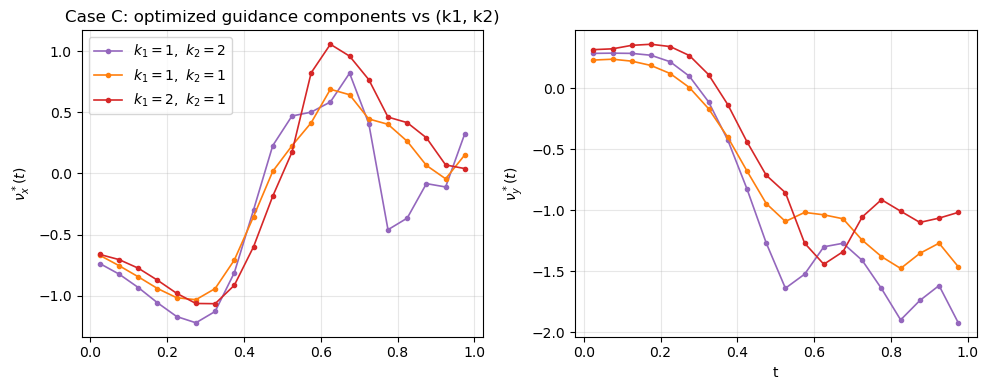

In [14]:

# -----------------------------------------------------------------------------
# 12. Figure: optimized ν_x(t), ν_y(t) for three (k1, k2) configurations
# -----------------------------------------------------------------------------

os.makedirs("results_caseC", exist_ok=True)

t_mid = 0.5 * (splits_pwc[:-1] + splits_pwc[1:])
trust_list_sorted = list(results_by_trust.keys())

fig, axes = plt.subplots(1, 2, figsize=(10.0, 4.0), sharex=True)

color_map = {
    (1, 2): "tab:purple",
    (1, 1): "tab:orange",
    (2, 1): "tab:red",
}

for (k1_cfg, k2_cfg) in trust_list_sorted:
    res = results_by_trust[(k1_cfg, k2_cfg)]
    nu_best = res["best_nu"]  # shape (K_pwc, 2)
    color = color_map.get((k1_cfg, k2_cfg), None)
    label = rf"$k_1={k1_cfg},\ k_2={k2_cfg}$"

    axes[0].plot(t_mid, nu_best[:, 0], marker="o", markersize=3,
                 linestyle="-", linewidth=1.2,
                 label=label, color=color)
    axes[1].plot(t_mid, nu_best[:, 1], marker="o", markersize=3,
                 linestyle="-", linewidth=1.2,
                 label=label, color=color)

axes[0].set_ylabel(r"$\nu_x^*(t)$")
axes[1].set_ylabel(r"$\nu_y^*(t)$")
axes[1].set_xlabel("t")

axes[0].set_title("Case C: optimized guidance components vs (k1, k2)")
for ax in axes:
    ax.grid(alpha=0.3)

axes[0].legend(loc="best")

fig.tight_layout()
nu_multi_path = os.path.join("results_caseC", "caseC_nu_opt_vs_t_multi_trust_bis.png")
fig.savefig(nu_multi_path, dpi=200, bbox_inches="tight")
print("[Figure] Saved multi-trust ν(t) figure to:", nu_multi_path)
plt.show()


[Snapshots] Simulating optimal paths for (k1, k2) = (1, 2)
[configure_caseC_for_trust] k1=1, k2=2
  Fused GMM modes: 12
  lambda_task1, lambda_task2 = 1.0 2.0
[Snapshots] Simulating optimal paths for (k1, k2) = (1, 1)
[configure_caseC_for_trust] k1=1, k2=1
  Fused GMM modes: 6
  lambda_task1, lambda_task2 = 1.0 1.0
[Snapshots] Simulating optimal paths for (k1, k2) = (2, 1)
[configure_caseC_for_trust] k1=2, k2=1
  Fused GMM modes: 18
  lambda_task1, lambda_task2 = 2.0 1.0
[Figure] Saved multi-trust snapshots (bis) figure to: results_caseC/caseC_snapshots_multi_trust_bis.png


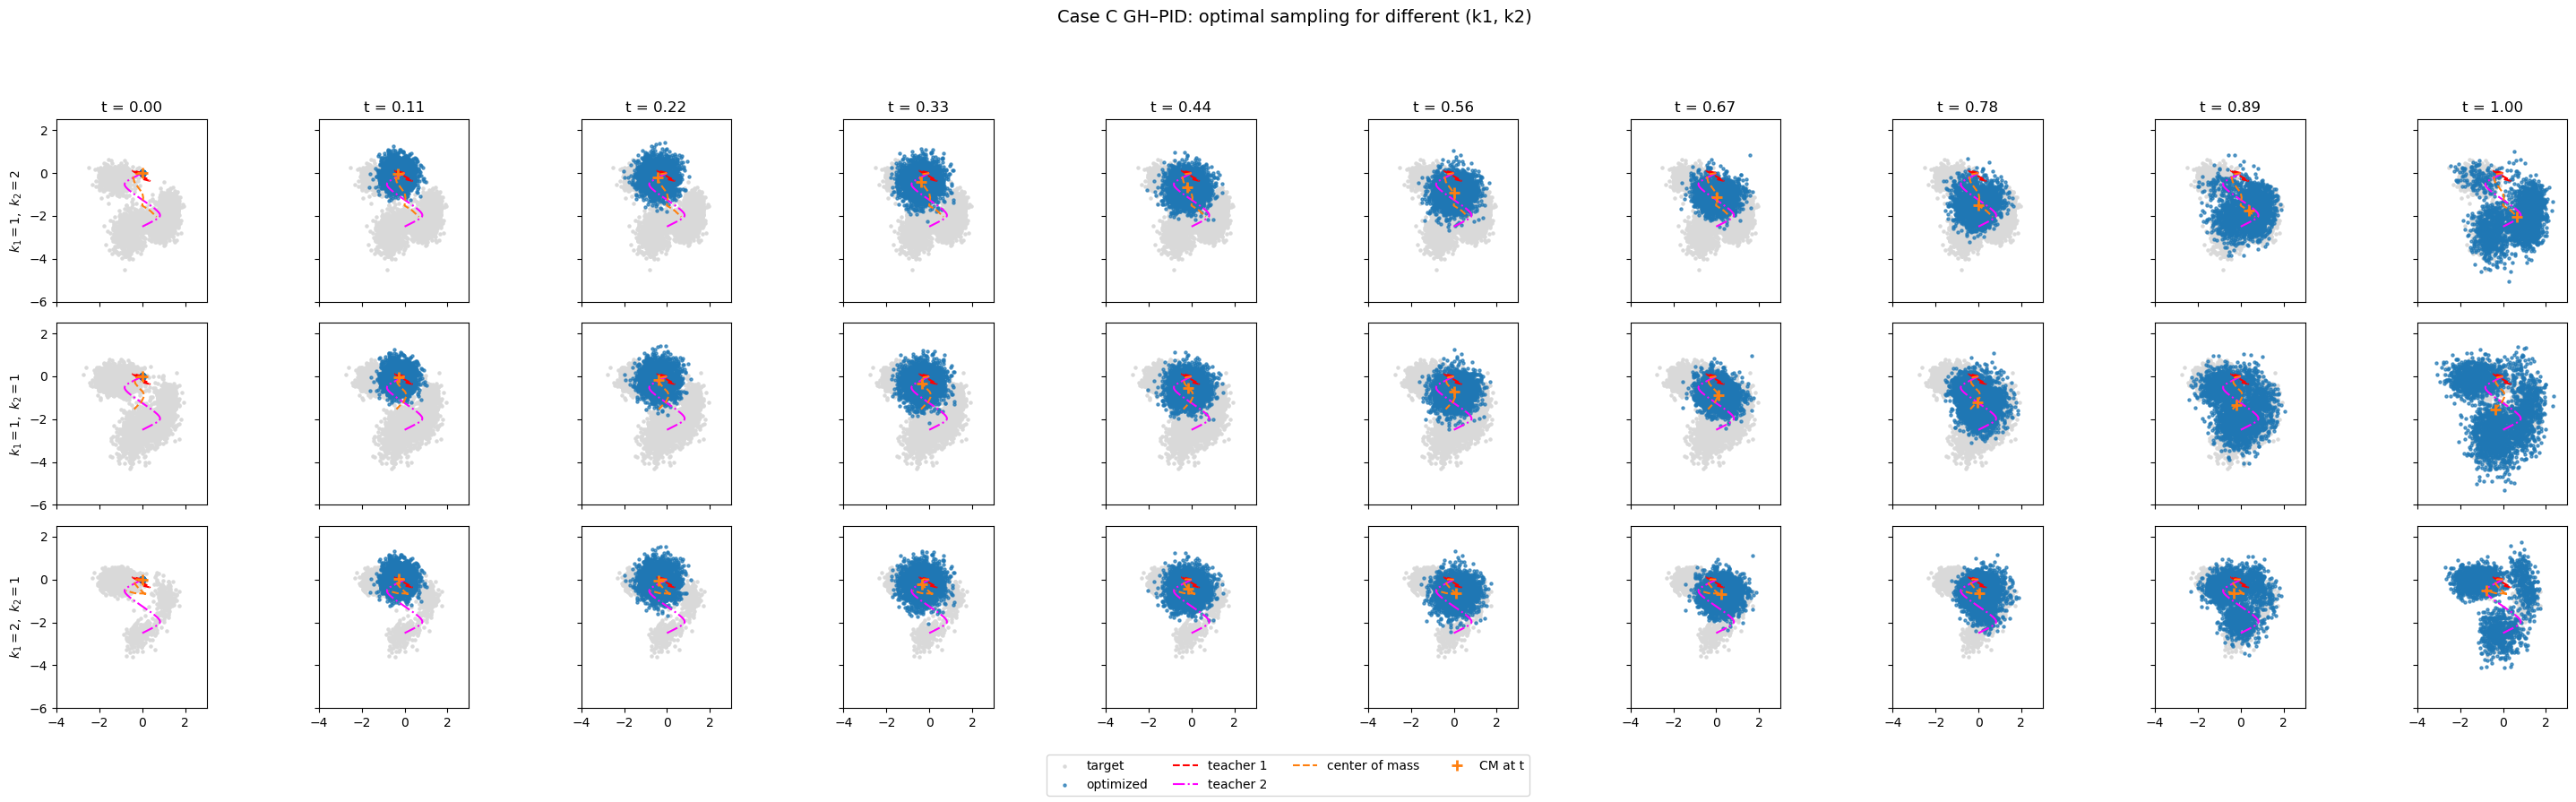

In [18]:
# -----------------------------------------------------------------------------
# 13. Multi-panel snapshots: optimal sampling for three (k1, k2) rows
# -----------------------------------------------------------------------------

# Helper: simulate paths and collect K snapshots over T steps
def simulate_paths_with_snapshots(sched, gmm_tar, snap_cfg, M=3000, seed=0):
    """
    Simulate GH–PID paths under 'sched' toward 'gmm_tar' and record snapshots.

    sched    : schedule object returned by build_schedule_from_param / build_schedule_from_pwc_numpy
    gmm_tar  : target GMM object (e.g., gmm_fused)
    snap_cfg : configuration object; we try to infer number of steps T and number of snapshots K
    M        : number of trajectories
    seed     : RNG seed
    """
    # Infer T and K from snap_cfg; fall back to defaults if missing
    T = getattr(snap_cfg, "T", 1000)   # total time steps
    K = getattr(snap_cfg, "N", 10)     # number of snapshots

    T = int(T)
    K = int(K)
    dt = 1.0 / float(T)

    torch.manual_seed(seed)
    X = torch.zeros(M, 2, device=device)

    # Choose snapshot indices uniformly over [0, T-1]
    snap_indices = np.linspace(0, T - 1, K, dtype=int)
    snap_index_set = set(int(i) for i in snap_indices)

    snaps = []
    times = []

    for n in range(T):
        t = (n + 0.5) * dt
        # Optimal drift under GH–PID toward the given target
        u = guided.ustar_guided(X, float(t), sched, gmm_tar)
        X = X + u * dt + torch.sqrt(torch.tensor(2.0 * dt, device=device)) * torch.randn_like(X)

        if n in snap_index_set:
            snaps.append(X.detach().cpu().numpy())
            times.append((n + 1) * dt)

    times = np.asarray(times, dtype=np.float32)
    return times, snaps


# Helper: build schedule from PWC numpy arrays, using existing build_schedule_from_param
def build_schedule_from_pwc_numpy(beta_vals_np, nu_vals_np, d, device):
    """
    Wrap build_schedule_from_param for numpy PWC arrays.

    beta_vals_np: (K_pwc,) numpy array of β_k
    nu_vals_np  : (K_pwc, d) numpy array of ν_k
    """
    beta_vals_t = torch.tensor(beta_vals_np, dtype=torch.float32, device=device)
    nu_vals_t   = torch.tensor(nu_vals_np,   dtype=torch.float32, device=device)
    return build_schedule_from_param(beta_vals_t, nu_vals_t, d=d, device=device)


# Simple local GMM sampler for targets
def sample_gmm_numpy(mu, cov, w, N, rng):
    """
    Simple NumPy GMM sampler: choose component by weights w, then
    draw from N(mu_k, cov_k). All inputs assumed as numpy arrays.
    """
    mu  = np.asarray(mu,  dtype=np.float32)   # (K, d)
    cov = np.asarray(cov, dtype=np.float32)   # (K, d, d)
    w   = np.asarray(w,   dtype=np.float32)   # (K,)

    K, d = mu.shape
    X = np.zeros((N, d), dtype=np.float32)

    for i in range(N):
        k = rng.choice(K, p=w)
        X[i, :] = rng.multivariate_normal(mu[k], cov[k]).astype(np.float32)

    return X


# We will reuse simulate_paths_with_snapshots from above and build a schedule
# from each optimized ν for every (k1, k2) in the trust grid.
os.makedirs("results_caseC", exist_ok=True)

# Use all saved snapshots (from t≈0 to t≈1)
indices_plot = list(range(10))

# Precompute teacher curves (same for all trust configurations)
t_dense = np.linspace(0.0, 1.0, 300)
teacher1_curve = np.stack([bar_nu1_cont(float(t)) for t in t_dense], axis=0)
teacher2_curve = np.stack([bar_nu2_cont(float(t)) for t in t_dense], axis=0)

snapshots_by_trust = {}
trust_list_sorted = list(results_by_trust.keys())

for (k1_cfg, k2_cfg) in trust_list_sorted:
    print(f"[Snapshots] Simulating optimal paths for (k1, k2) = ({k1_cfg}, {k2_cfg})")
    res = results_by_trust[(k1_cfg, k2_cfg)]

    # Reconfigure fused target and trust weights, build fused gmm_fused
    configure_caseC_for_trust(k1_cfg, k2_cfg)

    # Build optimal schedule from best ν and fixed bar_beta_vals
    nu_vals_np = res["best_nu"]
    sched_opt = build_schedule_from_pwc_numpy(
        beta_vals_np=bar_beta_vals,
        nu_vals_np=nu_vals_np,
        d=2,
        device=device,
    )

    # Simulate paths with snapshots under guided dynamics toward fused target
    times, snaps = simulate_paths_with_snapshots(
        sched_opt,
        gmm_fused,
        snap_cfg_caseC,
        M=3000,
        seed=7000,
    )

    # Sample target for visualization using local sampler
    rng_vis = np.random.default_rng(2026)
    X_tar = sample_gmm_numpy(mu_fused, cov_fused, w_fused, 4000, rng_vis)

    snapshots_by_trust[(k1_cfg, k2_cfg)] = {
        "times": times,
        "snaps": snaps,
        "X_tar": X_tar,
    }

# --- Build the 3×K grid of panels -------------------------------------------

rows = len(trust_list_sorted)
cols = len(indices_plot)
fig, axes = plt.subplots(rows, cols, figsize=(3.0 * cols, 3.0 * rows), sharex=True, sharey=True)

x_min, x_max = -4.0, 3.0
y_min, y_max = -6.0, 2.5

for row_idx, (k1_cfg, k2_cfg) in enumerate(trust_list_sorted):
    data = snapshots_by_trust[(k1_cfg, k2_cfg)]
    times = data["times"]
    snaps = data["snaps"]
    X_tar = data["X_tar"]

    for col_idx, idx_snap in enumerate(indices_plot):
        ax = axes[row_idx, col_idx] if rows > 1 else axes[col_idx]

        t = times[idx_snap]
        X_opt = snaps[idx_snap]

        # Target samples (background)
        ax.scatter(
            X_tar[:, 0], X_tar[:, 1],
            s=5, c="0.85",
            label="target" if (row_idx == 0 and col_idx == 0) else None,
            zorder=1,
        )
        # Optimized cloud
        ax.scatter(
            X_opt[:, 0], X_opt[:, 1],
            s=5, alpha=0.7,
            c="tab:blue",
            label="optimized" if (row_idx == 0 and col_idx == 0) else None,
            zorder=2,
        )

        # Teacher curves (on top of samples)
        ax.plot(
            teacher1_curve[:, 0], teacher1_curve[:, 1],
            linestyle="--", color="red", linewidth=1.5,
            label="teacher 1" if (row_idx == 0 and col_idx == 0) else None,
            zorder=3,
        )
        ax.plot(
            teacher2_curve[:, 0], teacher2_curve[:, 1],
            linestyle="-.", color="magenta", linewidth=1.5,
            label="teacher 2" if (row_idx == 0 and col_idx == 0) else None,
            zorder=3,
        )

        # Center-of-mass trajectory (orange dashed) and current CM (orange cross)
        cm_all = np.array([snap.mean(axis=0) for snap in snaps])  # shape (K,2)
        ax.plot(
            cm_all[:, 0], cm_all[:, 1],
            color="tab:orange", linestyle="--", linewidth=1.5,
            label="center of mass" if (row_idx == 0 and col_idx == 0) else None,
            zorder=4,
        )
        cm_t = cm_all[idx_snap]
        ax.plot(
            cm_t[0], cm_t[1],
            color="tab:orange",
            marker="+", linestyle="none",
            markersize=8, markeredgewidth=2.0,
            label="CM at t" if (row_idx == 0 and col_idx == 0) else None,
            zorder=5,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_aspect("equal", adjustable="box")

        if row_idx == 0:
            ax.set_title(f"t = {t:.2f}")
        if col_idx == 0:
            ax.set_ylabel(rf"$k_1={k1_cfg},\ k_2={k2_cfg}$")

# Global legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=4, fontsize=10)

fig.suptitle(
    "Case C GH–PID: optimal sampling for different (k1, k2)",
    fontsize=14,
)
plt.tight_layout(rect=[0, 0.07, 1, 0.92])

snap_multi_path = os.path.join("results_caseC", "caseC_snapshots_multi_trust_bis.png")
fig.savefig(snap_multi_path, dpi=200, bbox_inches="tight")
print("[Figure] Saved multi-trust snapshots (bis) figure to:", snap_multi_path)
plt.show()
